In [116]:
import os
import keras
import tensorflow as tf
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from lime import lime_image 
from skimage.segmentation import mark_boundaries
from flask import Flask, request, render_template, jsonify
import ipywidgets as widgets
from IPython.display import display 
import pandas as pd
from IPython.utils import io
import glob
import sys

with io.capture_output() as captured:
    print('Hello, world!')

notebook_dir = os.path.dirname(os.path.realpath('__file__'))

# List all files in the directory
files = os.listdir(notebook_dir)

# Filter out directories and get only filenames
module_filename = [f for f in files if ".h5" in f][0]
model = tf.keras.models.load_model(module_filename)
image_filename = [f for f in files if ".jpg" in f or ".png" in f][0]

temp= None
mask= None

def preprocess_image(ip):
	# swap color channels, preprocess the image, and add in a batch
	# dimension
	image = Image.open(ip).convert("RGB")
	data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
	size = (224, 224)
	image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)
	image_array = np.asarray(image)
	normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
	data[0] = normalized_image_array
	return data
 
def predict_image_class(image_path):
    # Preprocess the image
    prediction = model.predict(preprocess_image(image_path))
    index = np.argmax(prediction)
    confidence_score = prediction[0][index]
    return confidence_score, index

def create_lime(b):
    images = preprocess_image(image_filename)
    x,y = predict_image_class(image_filename)
    if y == 0:
        print("Bild als Sushi erkannt")
    else:
         print("Bild als Waffel erkannt")
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    return temp, mask

def update_values(b):
    global x, y
    x, y = create_lime(b)

def display_lime(b):
     global x,y
     plt.imshow(mark_boundaries(x / 2 + 0.5, y))

In [117]:
# Define your function

# Create a button widget
button = widgets.Button(description="Click me!")

# Define a function to handle button click event
def on_button_click(b):
    with open('nul', 'w') as null:
        sys.stdout = null  # Redirect stdout to null
        update_values(b)
        sys.stdout = sys.__stdout__  # Restore stdout

# Connect the function to the button click event
button.on_click(on_button_click)
# Display the button
display(button)

Button(description='Click me!', style=ButtonStyle())

  0%|          | 0/1000 [00:00<?, ?it/s]

Button(description='Click me!', style=ButtonStyle())

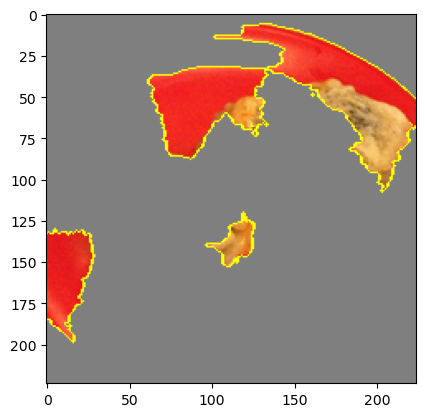

In [118]:
button2 = widgets.Button(description="Click me!")
button2.on_click(display_lime)
# Display the button
display(button2)